In [9]:
import shap
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from alibi.explainers import AnchorTabular
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.feature_selection import SelectFromModel
from alibi.confidence import TrustScore

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
failures = pd.read_csv('../data/model_data/failures.csv',sep=',')
components = failures['Component'].unique()

In [4]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'../data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['Turbine_ID'] = encoder.fit_transform(['Turbine_ID']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('Timestamp')

In [5]:
class_target_name = "Failure (Target)"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['Component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [6]:
model_name = "xgb"

In [7]:
for component in components:
    with open ('../main_pipeline/models_MLFLOW/selected-{}.pickle'.format(component), 'rb') as file:
        globals()[f"{model_name}_{component}"] = pickle.load(file)


In [8]:
for component in components:
    globals()[f"{model_name}_{component}"].fit(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"])
    globals()[f"{component}_params"] = globals()[f"{model_name}_{component}"].get_params()
    globals()[f"{component}_selector"] = SelectFromModel(globals()[f"{model_name}_{component}"], threshold=-np.inf, prefit=True, max_features=globals()[f"{component}_params"]['max_features'])
    globals()[f"{component}_selected_features"] = globals()[f"{component}_X_train"].columns[globals()[f"{component}_selector"].get_support()]
    globals()[f"{component}_selected_features_train"] = globals()[f"{component}_X_train"][globals()[f"{component}_selected_features"]]
    globals()[f"{component}_selected_features_test"] = globals()[f"{component}_X_test"][globals()[f"{component}_selected_features"]]
    globals()[f"{component}_selected_features_train"].reset_index(drop=True, inplace=True)
    globals()[f"{component}_selected_features_test"].reset_index(drop=True, inplace=True)

    globals()[f"{model_name}_{component}"].fit(globals()[f"{component}_selected_features_train"], globals()[f"{component}_y_train"])

In [11]:
classes = xgb_GEARBOX.classes_; len(classes)

2

In [40]:

ts = TrustScore(alpha=.05,
                filter_type='distance_knn',
                k_filter=10,
                leaf_size=40,
                metric='euclidean',
                dist_filter_type='point')

ts.fit(TRANSFORMER_selected_features_train.to_numpy(), TRANSFORMER_y_train.to_numpy(), classes=len(classes))
score = ts.score(TRANSFORMER_selected_features_test.to_numpy(), TRANSFORMER_y_test.to_numpy())


    

In [ ]:
HY

In [53]:
for component in components:
    globals()[f"{component}_ts"] = TrustScore(alpha=.05,
                filter_type='distance_knn',
                k_filter=10,
                leaf_size=40,
                metric='euclidean',
                dist_filter_type='point')
    globals()[f"{component}_ts"].fit(globals()[f"{component}_selected_features_train"].to_numpy(), globals()[f"{component}_y_train"].to_numpy(), classes=len(classes))

GEARBOX_scores = GEARBOX_ts.score(GEARBOX_selected_features_train.to_numpy(), GEARBOX_y_train.to_numpy(),k=3)
GENERATOR_scores = GENERATOR_ts.score(GENERATOR_selected_features_train.to_numpy(), GENERATOR_y_train.to_numpy(),k=3)
TRANSFORMER_scores = TRANSFORMER_ts.score(TRANSFORMER_selected_features_train.to_numpy(), TRANSFORMER_y_train.to_numpy(),k=3)
GENERATOR_BEARING_scores = GENERATOR_BEARING_ts.score(GENERATOR_BEARING_selected_features_train.to_numpy(), GENERATOR_BEARING_y_train.to_numpy(),k=3)
HYDRAULIC_GROUP_scores = HYDRAULIC_GROUP_ts.score(HYDRAULIC_GROUP_selected_features_train.to_numpy(), HYDRAULIC_GROUP_y_train.to_numpy(),k=3)


In [14]:
def detect_and_replace_outliers(arr, threshold):
    inlier_array = []
    outlier_array = []
    mean_val = np.mean(arr)
    std_dev = np.std(arr)
    upper_threshold = mean_val + threshold * std_dev

    for i, val in enumerate(arr):
        if val > upper_threshold:
            outlier_array.append({"index": i, "value": arr[i]})
        else:
            inlier_array.append({"index": i, "value": arr[i]})

    return inlier_array, outlier_array

In [50]:
components

array(['GEARBOX', 'GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING',
       'TRANSFORMER'], dtype=object)

In [54]:
for component in components:
   globals()[f"{component}_normal"], globals()[f"{component}_extremes"] = detect_and_replace_outliers(globals()[f"{component}_scores"][0].tolist(), 3)


In [18]:
def highlight_scatterplot(df, feature, highlight_indexes):
    # Create a new column in the DataFrame for the color
    df['color'] = 'blue'  # default color
    df.loc[highlight_indexes, 'color'] = 'red'  # highlight color

    plt.figure(figsize=(10, 6))

    # Scatterplot
    plt.scatter(df.index, df[feature], color=df['color'])
    plt.title('Scatterplot of Feature with Highlighted Points')
    plt.xlabel('Index')
    plt.ylabel(feature)

    # Remove the color column from the dataframe
    df = df.drop('color', axis=1)

    plt.show()

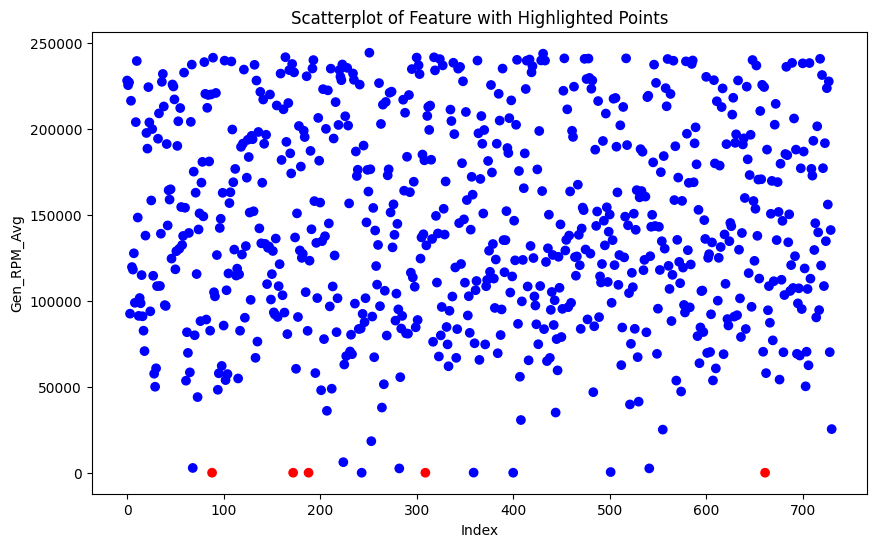

In [20]:
highlight_scatterplot(GEARBOX_selected_features_test, 'Gen_RPM_Avg', [88,172,188,309,661])
